# Практика: Векторные представления слов (Word Embeddings)

В этом ноутбуке мы разберём:
- Word2Vec: Skip-gram и CBOW
- Negative Sampling и техники оптимизации
- GloVe: объединение локального и глобального контекста
- FastText: устойчивость к OOV словам
- Оценка качества эмбеддингов
- Визуализация и анализ

Установите библиотеки:
```
pip install gensim scikit-learn numpy matplotlib seaborn umap-learn
```

## 1. Word2Vec: Skip-gram архитектура

In [1]:
import numpy as np
import matplotlib.pyplot as plt

print("=" * 70)
print("WORD2VEC: ИНТУИЦИЯ И РЕАЛИЗАЦИЯ")
print("=" * 70)

intro_text = """
Идея Word2Vec: You shall know a word by the company it keeps
  Слово определяется контекстом, в котором оно встречается.

Если слова часто встречаются в похожем контексте,
их векторы должны быть похожи.

Пример:
  'king' часто встречается в контексте 'queen', 'prince', 'royal'
  'queen' тоже встречается в контексте 'king', 'princess', 'royal'
  → Векторы 'king' и 'queen' должны быть близки
"""
print(intro_text)

WORD2VEC: ИНТУИЦИЯ И РЕАЛИЗАЦИЯ

Идея Word2Vec: You shall know a word by the company it keeps
  Слово определяется контекстом, в котором оно встречается.

Если слова часто встречаются в похожем контексте,
их векторы должны быть похожи.

Пример:
  'king' часто встречается в контексте 'queen', 'prince', 'royal'
  'queen' тоже встречается в контексте 'king', 'princess', 'royal'
  → Векторы 'king' и 'queen' должны быть близки



In [3]:
from gensim.models import Word2Vec, FastText
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

try:
    nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt')

print("=" * 70)
print("ОБУЧЕНИЕ WORD2VEC НА РЕАЛЬНОМ КОРПУСЕ")
print("=" * 70)

corpus = """
machine learning is a subset of artificial intelligence.
machine learning systems learn patterns from data.
deep learning uses neural networks with many layers.
neural networks are inspired by biological neurons.
artificial intelligence is transforming industries.
natural language processing analyzes human language.
text classification is a fundamental NLP task.
word embeddings capture semantic meaning.
word2vec learns word representations efficiently.
word similarity can be measured with embeddings.
"""

sentences = sent_tokenize(corpus.lower())
tokenized_sentences = [word_tokenize(sent) for sent in sentences]
tokenized_sentences = [
    [word for word in sent if word.isalnum()]
    for sent in tokenized_sentences
]

print(f"Корпус: {len(tokenized_sentences)} предложений")

# Skip-gram
model_sg = Word2Vec(
    tokenized_sentences,
    sg=1,
    vector_size=50,
    window=2,
    min_count=1,
    workers=4,
    epochs=20
)

print(f"Skip-gram обучена: {len(model_sg.wv)} слов")

# CBOW
model_cbow = Word2Vec(
    tokenized_sentences,
    sg=0,
    vector_size=50,
    window=2,
    min_count=1,
    workers=4,
    epochs=20
)

print(f"CBOW обучена: {len(model_cbow.wv)} слов")

ОБУЧЕНИЕ WORD2VEC НА РЕАЛЬНОМ КОРПУСЕ
Корпус: 10 предложений
Skip-gram обучена: 50 слов
CBOW обучена: 50 слов


## 2. Семантическое сходство и ближайшие соседи

In [4]:
print("=" * 70)
print("БЛИЖАЙШИЕ СОСЕДИ И СХОДСТВО")
print("=" * 70)

word = 'learning'
similar = model_sg.wv.most_similar(word, topn=5)

print(f"\nСлова похожие на '{word}':")
for sim_word, similarity in similar:
    print(f"  {sim_word:20} {similarity:.4f}")

# Косинусное сходство
w1, w2 = 'machine', 'learning'
sim = model_sg.wv.similarity(w1, w2)
print(f"\nСходство '{w1}' и '{w2}': {sim:.4f}")

# Матрица сходства
test_words = ['machine', 'learning', 'neural', 'data', 'language']
test_words = [w for w in test_words if w in model_sg.wv]

print(f"\nМатрица сходства ({len(test_words)} слов):")
sim_matrix = np.zeros((len(test_words), len(test_words)))

for i, w1 in enumerate(test_words):
    for j, w2 in enumerate(test_words):
        sim_matrix[i, j] = model_sg.wv.similarity(w1, w2)

for i, w in enumerate(test_words):
    print(f"{w:15} {' '.join(f'{sim_matrix[i, j]:6.3f}' for j in range(len(test_words)))}")

БЛИЖАЙШИЕ СОСЕДИ И СХОДСТВО

Слова похожие на 'learning':
  by                   0.2527
  biological           0.2496
  from                 0.2004
  learns               0.1979
  systems              0.1807

Сходство 'machine' и 'learning': 0.1575

Матрица сходства (5 слов):
machine          1.000  0.157  0.098 -0.127 -0.038
learning         0.157  1.000 -0.216  0.153  0.167
neural           0.098 -0.216  1.000 -0.084  0.137
data            -0.127  0.153 -0.084  1.000 -0.049
language        -0.038  0.167  0.137 -0.049  1.000


## 3. FastText для OOV слов

In [5]:
print("=" * 70)
print("FASTTEXT: ОБРАБОТКА OOV")
print("=" * 70)

model_ft = FastText(
    tokenized_sentences,
    vector_size=50,
    window=2,
    min_count=1,
    epochs=20,
    min_n=3,
    max_n=6
)

print(f"FastText словарь: {len(model_ft.wv)} слов")

# OOV слово
oov_word = 'machinelearning'

print(f"\nOOV слово: '{oov_word}'")

print("\nWord2Vec: ", end='')
try:
    vec = model_sg.wv[oov_word]
    print("есть вектор")
except:
    print("KeyError - нет в словаре")

print("FastText: ", end='')
try:
    vec = model_ft.wv[oov_word]
    print("есть вектор (из подслов)")
    print(f"  Первые 5 компонент: {vec[:5]}")
except:
    print("KeyError")

# Похожие слова
print(f"\nFastText: похожие на '{oov_word}':")
try:
    similar = model_ft.wv.most_similar(oov_word, topn=3)
    for word, score in similar:
        print(f"  {word:20} {score:.4f}")
except:
    print("  Не найдено")

FASTTEXT: ОБРАБОТКА OOV
FastText словарь: 50 слов

OOV слово: 'machinelearning'

Word2Vec: KeyError - нет в словаре
FastText: есть вектор (из подслов)
  Первые 5 компонент: [-0.00058464 -0.00061484 -0.00061939  0.00014508 -0.00176031]

FastText: похожие на 'machinelearning':
  learning             0.6729
  learn                0.4514
  machine              0.3192


## 4. Визуализация

ВИЗУАЛИЗАЦИЯ: t-SNE
Визуализируем 15 слов
Слова: ['word', 'is', 'learning', 'embeddings', 'language', 'with', 'networks', 'neural', 'intelligence', 'artificial', 'a', 'machine', 'measured', 'be', 'can']


/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


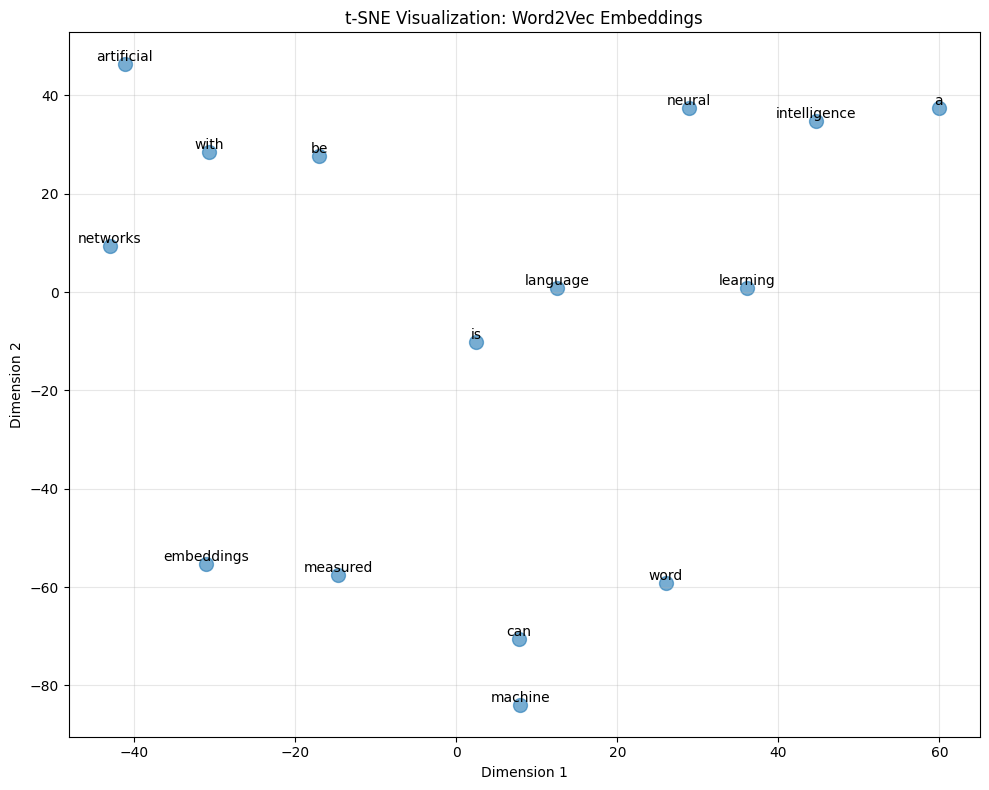

✓ Сохранено: embeddings_tsne.png


In [6]:
from sklearn.manifold import TSNE

print("=" * 70)
print("ВИЗУАЛИЗАЦИЯ: t-SNE")
print("=" * 70)

words = list(model_sg.wv.index_to_key[:15])
vectors = np.array([model_sg.wv[word] for word in words])

print(f"Визуализируем {len(words)} слов")
print(f"Слова: {words}")

tsne = TSNE(n_components=2, random_state=42, perplexity=3, n_iter=1000)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(10, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=100, alpha=0.6)

for i, word in enumerate(words):
    plt.annotate(word, 
                (vectors_2d[i, 0], vectors_2d[i, 1]),
                fontsize=10, ha='center', va='bottom')

plt.title('t-SNE Visualization: Word2Vec Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('embeddings_tsne.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Сохранено: embeddings_tsne.png")

## 5. Оценка качества

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("=" * 70)
print("ОЦЕНКА: КЛАССИФИКАЦИЯ ТЕКСТОВ")
print("=" * 70)

labeled_data = [
    ([t for t in 'machine learning is important'.split() if t.isalnum()], 'ml'),
    ([t for t in 'neural networks learn'.split() if t.isalnum()], 'ml'),
    ([t for t in 'deep learning networks'.split() if t.isalnum()], 'ml'),
    ([t for t in 'natural language text'.split() if t.isalnum()], 'nlp'),
    ([t for t in 'text processing language'.split() if t.isalnum()], 'nlp'),
]

X = []
y = []

for tokens, label in labeled_data:
    vectors = [model_sg.wv[t] for t in tokens if t in model_sg.wv]
    if vectors:
        X.append(np.mean(vectors, axis=0))
        y.append(label)

X = np.array(X)
y_num = np.array([0 if yi == 'ml' else 1 for yi in y])

clf = LogisticRegression(max_iter=200)
clf.fit(X, y_num)
y_pred = clf.predict(X)

acc = accuracy_score(y_num, y_pred)

print(f"\nДокументов: {len(X)}")
print(f"Точность: {acc:.1%}")
print(f"\nПредсказания: {['ML' if p == 0 else 'NLP' for p in y_pred]}")
print(f"Истинные:     {['ML' if p == 0 else 'NLP' for p in y_num]}")

ОЦЕНКА: КЛАССИФИКАЦИЯ ТЕКСТОВ

Документов: 5
Точность: 60.0%

Предсказания: ['ML', 'ML', 'ML', 'ML', 'ML']
Истинные:     ['ML', 'ML', 'ML', 'NLP', 'NLP']


## 6. Сравнение методов

In [23]:
print("=" * 70)
print("СРАВНЕНИЕ: Skip-gram vs CBOW vs FastText")
print("=" * 70)

table = f"""
{"Характеристика":30} {"Skip-gram":15} {"CBOW":15} {"FastText":15}
{"="*75}
{"Скорость":30} {"⭐⭐":15} {"⭐⭐⭐":13} {"⭐⭐":15}
{"Качество редких слов":30} {"⭐⭐⭐":14} {"⭐":15} {"⭐⭐⭐":15}
{"OOV обработка":30} {"✗":18} {"✗":18} {"✓":15}
{"Частые слова":30} {"⭐⭐":15} {"⭐⭐⭐":13} {"⭐⭐⭐":15}
{"Простота":30} {"Средняя":17} {"Легко":16} {"Средняя":15}
"""

print(table)

print("\nРекомендации:")
print("• Skip-gram: большие данные, много редких слов")
print("• CBOW: малые данные, быстро")
print("• FastText: OOV слова, морфология важна (русский, финский)")

СРАВНЕНИЕ: Skip-gram vs CBOW vs FastText

Характеристика                 Skip-gram       CBOW            FastText       
Скорость                       ⭐⭐              ⭐⭐⭐           ⭐⭐             
Качество редких слов           ⭐⭐⭐            ⭐               ⭐⭐⭐            
OOV обработка                  ✗                  ✗                  ✓              
Частые слова                   ⭐⭐              ⭐⭐⭐           ⭐⭐⭐            
Простота                       Средняя           Легко            Средняя        


Рекомендации:
• Skip-gram: большие данные, много редких слов
• CBOW: малые данные, быстро
• FastText: OOV слова, морфология важна (русский, финский)
